In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import statistics
import Game

class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dim, actions, device):
        super(DeepQNetwork, self).__init__()
        self.input_dim = input_dim
        self.fc1Dim = 64
        self.fc2Dim = 64
        self.fc3Dim = 64
        self.actions = actions
        self.fc1 = nn.Linear(*self.input_dim, self.fc1Dim)
        self.fc2 = nn.Linear(self.fc1Dim, self.fc2Dim)
        self.fc3 = nn.Linear(self.fc2Dim, self.fc3Dim)
        self.fc4 = nn.Linear(self.fc3Dim, self.actions)
        
        self.opt = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = device
        self.to(device)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#Deep Q learning
class Agent():
    def __init__(self, gamma, epsilon, lr, inputDims, batchSize, actions, maxMem=100000, epsEnd=0.05, epsDec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsMin = epsEnd
        self.epsDec = epsDec
        self.lr = lr
        self.actionSpace = [i for i in range(actions)]
        self.memSize = maxMem
        self.batchSize = batchSize
        self.memCntr = 0
        self.iterCntr = 0
        self.Q_eval = DeepQNetwork(lr, inputDims, actions, T.device('mps'))
        self.device = T.device('mps')
        self.stateMemory = np.zeros((self.memSize, *inputDims), dtype=np.float32)
        self.newStateMemory = np.zeros((self.memSize, *inputDims), dtype=np.float32)
        self.actionMemory = np.zeros((self.memSize), dtype=np.int32)
        self.rewardMemory = np.zeros(self.memSize, dtype=np.float32)
        self.terminalMemory = np.zeros(self.memSize, dtype=bool)
    
    def storeTransition(self, state, action, reward, state_, terminal):
        idx = self.memCntr % self.memSize
        self.stateMemory[idx] = state
        self.newStateMemory[idx] = state_
        self.rewardMemory[idx] = reward
        self.actionMemory[idx] = action
        self.terminalMemory[idx] = terminal
        self.memCntr += 1

    def chooseAction(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.actionSpace)
        return action
    
    def learn(self):
        if self.memCntr < self.batchSize:
            return
        
        self.Q_eval.opt.zero_grad()
        maxMem = min(self.memCntr, self.memSize)
        batch = np.random.choice(maxMem, self.batchSize, replace=False)
        batchIndex = np.arange(self.batchSize, dtype=np.int32)
        
        StateBatch = T.tensor(self.stateMemory[batch]).to(self.Q_eval.device)
        newStateBatch = T.tensor(self.newStateMemory[batch]).to(self.Q_eval.device)
        actionBatch = self.actionMemory[batch]
        rewardBatch = T.tensor(self.rewardMemory[batch]).to(self.Q_eval.device)
        terminalBatch = T.tensor(self.terminalMemory[batch]).to(self.Q_eval.device)

        qEval = self.Q_eval.forward(StateBatch)[batchIndex, actionBatch]
        qNext = self.Q_eval.forward(newStateBatch)
        qNext[terminalBatch] = 0.0

        qTarget = rewardBatch + self.gamma*T.max(qNext, dim=1)[0]

        loss = self.Q_eval.loss(qTarget, qEval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.opt.step()

        self.iterCntr += 1
        self.epsilon -= self.epsDec
        self.epsilon = max(self.epsilon, self.epsMin)

In [2]:
if __name__ == '__main__':
    plot = []
    env = Game.ShowerEnv()
    agent = Agent(gamma=0.99, epsilon=1.0, batchSize=64, actions=3, epsEnd=0.01,
                  inputDims=[1], lr=0.001, epsDec=0.0001)
    scores, eps_history = [-100], []
    n_games = 250
    
    for i in trange(n_games):
        score = 0
        done = False
        observation = env.reset()
        while not done:
            action = agent.chooseAction(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.storeTransition(observation, action, reward, observation_, done)
            agent.learn()
            observation = observation_
        scores.append(score)
        eps_history.append(agent.epsilon * 100)

        avg_score = statistics.mean(np.array(scores[-20:]))
        plot.append(avg_score)


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/4y/y2r7rtj90w50wr7fv5zd3vkh0000gp/T/ipykernel_11801/354313610.py:92: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  qNext[terminalBatch] = 0.0
100%|██████████| 250/250 [04:32<00:00,  1.09s/it]


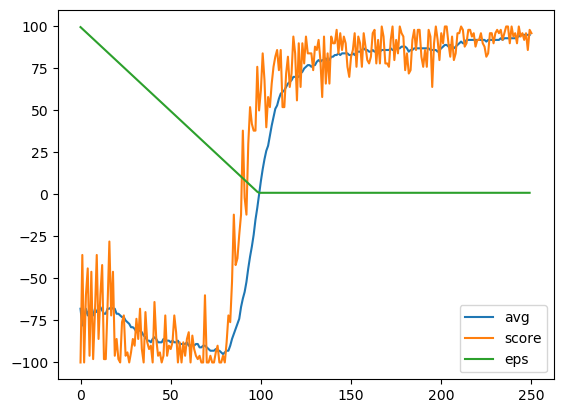

In [5]:
plt.plot(plot, label='avg')
plt.plot(scores, label='score')
plt.plot(eps_history, label='eps')
plt.legend()